# Exploratory Data Analysis: Music Genre Popularity & Features

**Objective:** This notebook performs an exploratory data analysis on the `model_dataset_weekly.csv` to understand trends, patterns, and characteristics of music genre popularity and associated features over time. This EDA will help inform the forecasting models.

**Dataset:** `model_dataset_weekly.csv` (contains weekly data on songs, artists, streams, chart positions, Deezer genres, processed AcousticBrainz features, Last.fm features, engineered features from Deezer release dates, and other Deezer track/album features).

**Context:** This dataset is generated by an ETL pipeline (`10_cleaning.py`, `50_merge_features.py`, `60_merge_timeseries.py`), which performs merging, feature engineering (lags, rolling stats, OHE for genres/tags, release date features), and cleaning. AcousticBrainz probability features are expected to be binarized, and corresponding `_value` columns dropped by the ETL.

## 1. Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys 
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
plt.style.use('ggplot')
sns.set_palette('viridis')

In [2]:
import os

plot_counter = 1  # Global plot counter

def save_and_show():
    global plot_counter
    os.makedirs('../outputs/plots/EDA', exist_ok=True)
    plt.savefig(f'../outputs/plots/EDA/plot_{plot_counter:02d}.png', bbox_inches='tight')
    plt.show()
    plot_counter += 1


In [3]:
df = pd.read_csv(
    "../data/processed/model_dataset_weekly.csv",
    parse_dates=["date"], 
    dayfirst=False
)
print(f"{len(df):,} rows × {df.shape[1]} columns loaded")
df.head()

85,620 rows × 135 columns loaded


,artist,song,spotify_position,spotify_last_week,spotify_peak_position,spotify_weeks_on_chart,spotify_streams,acoustic_ab_danceability_prob,acoustic_ab_gender_prob,acoustic_ab_genre_dortmund_prob,acoustic_ab_genre_electronic_prob,acoustic_ab_genre_rosamerica_prob,acoustic_ab_ismir04_rhythm_prob,acoustic_ab_mood_acoustic_prob,acoustic_ab_mood_aggressive_value,acoustic_ab_mood_electronic_prob,acoustic_ab_mood_happy_prob,acoustic_ab_mood_party_prob,acoustic_ab_mood_relaxed_prob,acoustic_ab_mood_sad_prob,acoustic_ab_moods_mirex_prob,acoustic_ab_timbre_prob,acoustic_ab_tonal_atonal_prob,acoustic_ab_voice_instrumental_prob,deezer_duration_sec,deezer_explicit_lyrics,deezer_bpm,deezer_gain,deezer_release_date,deezer_album_track_count,deezer_album_duration_sec,deezer_album_explicit_lyrics,deezer_genre_african_music,deezer_genre_alternative,deezer_genre_asian_music,deezer_genre_blues,deezer_genre_bollywood,deezer_genre_brazilian_music,deezer_genre_chill_out_trip-hop_lounge,deezer_genre_classical,deezer_genre_comedy,deezer_genre_contemporary_randb,deezer_genre_corridos,deezer_genre_dance,deezer_genre_dancehall_ragga,deezer_genre_dirty_south,deezer_genre_disco,deezer_genre_dub,deezer_genre_dubstep,deezer_genre_east_coast,deezer_genre_electro,deezer_genre_electro_pop_electro_rock,deezer_genre_film_scores,deezer_genre_films_games,deezer_genre_folk,deezer_genre_hard_rock,deezer_genre_indian_music,deezer_genre_indie_pop,deezer_genre_indie_pop_folk,deezer_genre_indie_rock,deezer_genre_indie_rock_rock_pop,deezer_genre_international_pop,deezer_genre_jazz,deezer_genre_kids,deezer_genre_latin_music,deezer_genre_metal,deezer_genre_musicals,deezer_genre_norteño,deezer_genre_opera,deezer_genre_pop,deezer_genre_randb,deezer_genre_ranchera,deezer_genre_rap_hip_hop,deezer_genre_reggae,deezer_genre_rock,deezer_genre_rock_and_roll_rockabilly,deezer_genre_singer_and_songwriter,deezer_genre_ska,deezer_genre_soul_and_funk,deezer_genre_techno_house,deezer_genre_trance,lastfm_album_name,lastfm_duration_ms,lastfm_playcount,lastfm_listeners,lfm_tag_pop,lfm_tag_rap,lfm_tag_hip_hop,lfm_tag_trap,lfm_tag_myspotigrambot,lfm_tag_rnb,lfm_tag_electronic,lfm_tag_rock,lfm_tag_dance,lfm_tag_alternative,lfm_tag_k_pop,lfm_tag_2010s,lfm_tag_indie,lfm_tag_electropop,lfm_tag_reggaeton,lfm_tag_soul,lfm_tag_pop_rock,lfm_tag_pop_rap,lfm_tag_awesome,lfm_tag_female_vocalists,lfm_tag_house,lfm_tag_alternative_rock,lfm_tag_latin,lfm_tag_christmas,date,song_age_days,release_year,release_month,release_dayofweek,is_new_release_last_28d,spotify_days_on_chart,year,month,quarter,weekofyear,spotify_streams_lag_1,spotify_streams_lag_2,spotify_streams_lag_4,spotify_streams_lag_8,spotify_streams_lag_12,spotify_streams_roll_mean_4,spotify_streams_roll_std_4,spotify_streams_roll_mean_8,spotify_streams_roll_std_8,spotify_streams_roll_mean_12,spotify_streams_roll_std_12,dART_album,dART_compile,dART_ep,dART_single
0,Maluma,Borro Cassette,141.0,141.0,NaN,1.0,3542282.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,not_aggressive,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,222.0,False,176.70,-9.4,2015-10-02,1.0,222.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Pretty Boy, Dirty Boy",217000.0,2043310.0,243760.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2017-01-01,457,2015,10,4,0,7.0,2017,1,1,52,NaN,NaN,NaN,NaN,NaN,3542282.0,NaN,3542282.0,NaN,3542282.0,NaN,False,False,False,True
1,John Williams,Carol of the Bells,171.0,171.0,NaN,1.0,3123441.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,not_aggressive,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,85.0,False,NaN,-20.5,2022-11-14,65.0,4939.0,False,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Advent - De mest älskade julsångerna (2021),85000.0,777009.0,288774.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2017-01-01,-2143,2022,11,0,0,7.0,2017,1,1,52,NaN,NaN,NaN,NaN,NaN,3123441.0,NaN,3123441.0,NaN,3123441.0,NaN,True,False,False,False
2,Major Lazer,Cold Water,14.0,14.0,NaN,1.0,13143341.0,1.0

## 2. Initial Data Inspection

In [4]:
if not df.empty:
    print("First 5 rows of the dataset:")
    display(df.head())
else:
    print("DataFrame is empty, skipping head display.")

First 5 rows of the dataset:


,artist,song,spotify_position,spotify_last_week,spotify_peak_position,spotify_weeks_on_chart,spotify_streams,acoustic_ab_danceability_prob,acoustic_ab_gender_prob,acoustic_ab_genre_dortmund_prob,acoustic_ab_genre_electronic_prob,acoustic_ab_genre_rosamerica_prob,acoustic_ab_ismir04_rhythm_prob,acoustic_ab_mood_acoustic_prob,acoustic_ab_mood_aggressive_value,acoustic_ab_mood_electronic_prob,acoustic_ab_mood_happy_prob,acoustic_ab_mood_party_prob,acoustic_ab_mood_relaxed_prob,acoustic_ab_mood_sad_prob,acoustic_ab_moods_mirex_prob,acoustic_ab_timbre_prob,acoustic_ab_tonal_atonal_prob,acoustic_ab_voice_instrumental_prob,deezer_duration_sec,deezer_explicit_lyrics,deezer_bpm,deezer_gain,deezer_release_date,deezer_album_track_count,deezer_album_duration_sec,deezer_album_explicit_lyrics,deezer_genre_african_music,deezer_genre_alternative,deezer_genre_asian_music,deezer_genre_blues,deezer_genre_bollywood,deezer_genre_brazilian_music,deezer_genre_chill_out_trip-hop_lounge,deezer_genre_classical,deezer_genre_comedy,deezer_genre_contemporary_randb,deezer_genre_corridos,deezer_genre_dance,deezer_genre_dancehall_ragga,deezer_genre_dirty_south,deezer_genre_disco,deezer_genre_dub,deezer_genre_dubstep,deezer_genre_east_coast,deezer_genre_electro,deezer_genre_electro_pop_electro_rock,deezer_genre_film_scores,deezer_genre_films_games,deezer_genre_folk,deezer_genre_hard_rock,deezer_genre_indian_music,deezer_genre_indie_pop,deezer_genre_indie_pop_folk,deezer_genre_indie_rock,deezer_genre_indie_rock_rock_pop,deezer_genre_international_pop,deezer_genre_jazz,deezer_genre_kids,deezer_genre_latin_music,deezer_genre_metal,deezer_genre_musicals,deezer_genre_norteño,deezer_genre_opera,deezer_genre_pop,deezer_genre_randb,deezer_genre_ranchera,deezer_genre_rap_hip_hop,deezer_genre_reggae,deezer_genre_rock,deezer_genre_rock_and_roll_rockabilly,deezer_genre_singer_and_songwriter,deezer_genre_ska,deezer_genre_soul_and_funk,deezer_genre_techno_house,deezer_genre_trance,lastfm_album_name,lastfm_duration_ms,lastfm_playcount,lastfm_listeners,lfm_tag_pop,lfm_tag_rap,lfm_tag_hip_hop,lfm_tag_trap,lfm_tag_myspotigrambot,lfm_tag_rnb,lfm_tag_electronic,lfm_tag_rock,lfm_tag_dance,lfm_tag_alternative,lfm_tag_k_pop,lfm_tag_2010s,lfm_tag_indie,lfm_tag_electropop,lfm_tag_reggaeton,lfm_tag_soul,lfm_tag_pop_rock,lfm_tag_pop_rap,lfm_tag_awesome,lfm_tag_female_vocalists,lfm_tag_house,lfm_tag_alternative_rock,lfm_tag_latin,lfm_tag_christmas,date,song_age_days,release_year,release_month,release_dayofweek,is_new_release_last_28d,spotify_days_on_chart,year,month,quarter,weekofyear,spotify_streams_lag_1,spotify_streams_lag_2,spotify_streams_lag_4,spotify_streams_lag_8,spotify_streams_lag_12,spotify_streams_roll_mean_4,spotify_streams_roll_std_4,spotify_streams_roll_mean_8,spotify_streams_roll_std_8,spotify_streams_roll_mean_12,spotify_streams_roll_std_12,dART_album,dART_compile,dART_ep,dART_single
0,Maluma,Borro Cassette,141.0,141.0,NaN,1.0,3542282.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,not_aggressive,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,222.0,False,176.70,-9.4,2015-10-02,1.0,222.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Pretty Boy, Dirty Boy",217000.0,2043310.0,243760.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2017-01-01,457,2015,10,4,0,7.0,2017,1,1,52,NaN,NaN,NaN,NaN,NaN,3542282.0,NaN,3542282.0,NaN,3542282.0,NaN,False,False,False,True
1,John Williams,Carol of the Bells,171.0,171.0,NaN,1.0,3123441.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,not_aggressive,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,85.0,False,NaN,-20.5,2022-11-14,65.0,4939.0,False,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Advent - De mest älskade julsångerna (2021),85000.0,777009.0,288774.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2017-01-01,-2143,2022,11,0,0,7.0,2017,1,1,52,NaN,NaN,NaN,NaN,NaN,3123441.0,NaN,3123441.0,NaN,3123441.0,NaN,True,False,False,False
2,Major Lazer,Cold Water,14.0,14.0,NaN,1.0,13143341.0,1.0

In [5]:
if not df.empty:
    print("\nDataset Information:")
    df.info(verbose=True, show_counts=True)
else:
    print("DataFrame is empty, skipping info display.")


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85620 entries, 0 to 85619
Data columns (total 135 columns):
 #    Column                                  Non-Null Count  Dtype         
---   ------                                  --------------  -----         
 0    artist                                  85620 non-null  object        
 1    song                                    85620 non-null  object        
 2    spotify_position                        85620 non-null  float64       
 3    spotify_last_week                       85620 non-null  float64       
 4    spotify_peak_position                   76773 non-null  float64       
 5    spotify_weeks_on_chart                  85620 non-null  float64       
 6    spotify_streams                         85620 non-null  float64       
 7    acoustic_ab_danceability_prob           25148 non-null  float64       
 8    acoustic_ab_gender_prob                 25148 non-null  float64       
 9    acoustic_ab_gen

**Observations from `.info()`:**
- Verify 'date' column is datetime type.
- Check data types of Last.fm columns, Deezer release date features, and additional Deezer features like `deezer_album_track_count`, `deezer_album_duration_sec`, `deezer_bpm`, `deezer_duration_sec`. These should be numeric.
- Note columns with missing values.

In [6]:
if not df.empty:
    print("\nDescriptive Statistics (Numerical Columns):")
    display(df.describe())
else:
    print("DataFrame is empty, skipping describe display.")


Descriptive Statistics (Numerical Columns):


,spotify_position,spotify_last_week,spotify_peak_position,spotify_weeks_on_chart,spotify_streams,acoustic_ab_danceability_prob,acoustic_ab_gender_prob,acoustic_ab_genre_dortmund_prob,acoustic_ab_genre_electronic_prob,acoustic_ab_genre_rosamerica_prob,acoustic_ab_ismir04_rhythm_prob,acoustic_ab_mood_acoustic_prob,acoustic_ab_mood_electronic_prob,acoustic_ab_mood_happy_prob,acoustic_ab_mood_party_prob,acoustic_ab_mood_relaxed_prob,acoustic_ab_mood_sad_prob,acoustic_ab_moods_mirex_prob,acoustic_ab_timbre_prob,acoustic_ab_tonal_atonal_prob,acoustic_ab_voice_instrumental_prob,deezer_duration_sec,deezer_bpm,deezer_gain,deezer_album_track_count,deezer_album_duration_sec,deezer_genre_african_music,deezer_genre_alternative,deezer_genre_asian_music,deezer_genre_blues,deezer_genre_bollywood,deezer_genre_brazilian_music,deezer_genre_chill_out_trip-hop_lounge,deezer_genre_classical,deezer_genre_comedy,deezer_genre_contemporary_randb,deezer_genre_corridos,deezer_genre_dance,deezer_genre_dancehall_ragga,deezer_genre_dirty_south,deezer_genre_disco,deezer_genre_dub,deezer_genre_dubstep,deezer_genre_east_coast,deezer_genre_electro,deezer_genre_electro_pop_electro_rock,deezer_genre_film_scores,deezer_genre_films_games,deezer_genre_folk,deezer_genre_hard_rock,deezer_genre_indian_music,deezer_genre_indie_pop,deezer_genre_indie_pop_folk,deezer_genre_indie_rock,deezer_genre_indie_rock_rock_pop,deezer_genre_international_pop,deezer_genre_jazz,deezer_genre_kids,deezer_genre_latin_music,deezer_genre_metal,deezer_genre_musicals,deezer_genre_norteño,deezer_genre_opera,deezer_genre_pop,deezer_genre_randb,deezer_genre_ranchera,deezer_genre_rap_hip_hop,deezer_genre_reggae,deezer_genre_rock,deezer_genre_rock_and_roll_rockabilly,deezer_genre_singer_and_songwriter,deezer_genre_ska,deezer_genre_soul_and_funk,deezer_genre_techno_house,deezer_genre_trance,lastfm_duration_ms,lastfm_playcount,lastfm_listeners,lfm_tag_pop,lfm_tag_rap,lfm_tag_hip_hop,lfm_tag_trap,lfm_tag_myspotigrambot,lfm_tag_rnb,lfm_tag_electronic,lfm_tag_rock,lfm_tag_dance,lfm_tag_alternative,lfm_tag_k_pop,lfm_tag_2010s,lfm_tag_indie,lfm_tag_electropop,lfm_tag_reggaeton,lfm_tag_soul,lfm_tag_pop_rock,lfm_tag_pop_rap,lfm_tag_awesome,lfm_tag_female_vocalists,lfm_tag_house,lfm_tag_alternative_rock,lfm_tag_latin,lfm_tag_christmas,date,song_age_days,release_year,release_month,release_dayofweek,is_new_release_last_28d,spotify_days_on_chart,year,month,quarter,weekofyear,spotify_streams_lag_1,spotify_streams_lag_2,spotify_streams_lag_4,spotify_streams_lag_8,spotify_streams_lag_12,spotify_streams_roll_mean_4,spotify_streams_roll_std_4,spotify_streams_roll_mean_8,spotify_streams_roll_std_8,spotify_streams_roll_mean_12,spotify_streams_roll_std_12
count,85620.000000,85620.000000,76773.000000,85620.000000,8.562000e+04,25148.000000,25148.000000,25148.000000,25148.000000,25148.000000,25148.000000,25148.000000,25148.000000,25148.000000,25148.000000,25148.000000,25148.000000,25148.000000,25148.000000,25148.000000,25148.000000,69333.000000,28038.000000,68772.000000,68882.000000,68882.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.0,85620.000000,85620.000000,85620.000000,85620.0,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.0,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.0,85620.000000,85620.000000,85620.000000,64930.000000,8.561900e+04,8.561900e+04,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.00000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85620.000000,85

**Observations from Numerical `.describe()`:**
- Examine ranges for Last.fm features, Deezer release date features, and additional Deezer numeric features.
  - `deezer_bpm`: Check min/max for typical BPM ranges.
  - `deezer_duration_sec`, `deezer_album_duration_sec`: Check for reasonable song/album lengths.
  - `deezer_album_track_count`: Check for typical album track counts.

In [7]:
if not df.empty:
    print("\nDescriptive Statistics (Categorical/Object Columns):")
    display(df.describe(include=['object', 'category']))
else:
    print("DataFrame is empty, skipping describe for object types.")


Descriptive Statistics (Categorical/Object Columns):


,artist,song,acoustic_ab_mood_aggressive_value,deezer_explicit_lyrics,deezer_release_date,deezer_album_explicit_lyrics,lastfm_album_name
count,85620,85620,25148,69333,68882,68882,64001
unique,1390,5775,2,2,1387,2,2653
top,The Weeknd,Believer,not_aggressive,False,2025-04-26,True,÷ (Deluxe)
freq,1852,408,24064,46840,2201,35751,986


## 3. Data Cleaning and Preprocessing (Verification)

### 3.1. Missing Values (Post-ETL)

In [8]:
if not df.empty:
    print("Missing values per column (%):")
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))
else:
    print("DataFrame is empty, skipping missing value check.")

Missing values per column (%):
acoustic_ab_timbre_prob                70.628358
acoustic_ab_mood_electronic_prob       70.628358
acoustic_ab_danceability_prob          70.628358
acoustic_ab_voice_instrumental_prob    70.628358
acoustic_ab_tonal_atonal_prob          70.628358
acoustic_ab_moods_mirex_prob           70.628358
acoustic_ab_mood_sad_prob              70.628358
acoustic_ab_mood_relaxed_prob          70.628358
acoustic_ab_mood_happy_prob            70.628358
acoustic_ab_mood_party_prob            70.628358
acoustic_ab_mood_aggressive_value      70.628358
acoustic_ab_mood_acoustic_prob         70.628358
acoustic_ab_ismir04_rhythm_prob        70.628358
acoustic_ab_genre_rosamerica_prob      70.628358
acoustic_ab_genre_electronic_prob      70.628358
acoustic_ab_genre_dortmund_prob        70.628358
acoustic_ab_gender_prob                70.628358
deezer_bpm                             67.252978
spotify_streams_lag_12                 41.498482
spotify_streams_lag_8                 

### 3.2. Verify Data Types (Post-ETL)

In [9]:
if not df.empty:
    if 'date' in df.columns:
        if not pd.api.types.is_datetime64_any_dtype(df['date']):
             print("Warning: 'date' column is not datetime. Attempting conversion.")
             df['date'] = pd.to_datetime(df['date'], errors='coerce')
        else:
            print("'date' column is already datetime dtype.")
    
    # Verify Last.fm numeric columns
    lastfm_numeric_cols_to_check = ['lastfm_listeners', 'lastfm_playcount', 'lastfm_duration_ms']
    for col in lastfm_numeric_cols_to_check:
        if col in df.columns:
            if not pd.api.types.is_numeric_dtype(df[col]):
                print(f"Warning: Last.fm column '{col}' is not numeric. Type: {df[col].dtype}")
            else:
                print(f"Last.fm column '{col}' is numeric. Type: {df[col].dtype}")
        else:
            print(f"Warning: Expected Last.fm numeric column '{col}' not found.")

    # Verify Deezer Release Date engineered features
    deezer_release_engineered_cols = ['song_age_days', 'release_year', 'release_month', 'release_dayofweek', 'is_new_release_last_28d']
    for col in deezer_release_engineered_cols:
        if col in df.columns:
            if not pd.api.types.is_numeric_dtype(df[col]): 
                print(f"Warning: Deezer release feature '{col}' is not numeric. Type: {df[col].dtype}")
            else:
                print(f"Deezer release feature '{col}' is numeric. Type: {df[col].dtype}")
        else:
            print(f"Warning: Expected Deezer release feature '{col}' not found.")

    # Verify other Deezer numeric features
    other_deezer_numeric_cols = ['deezer_album_track_count', 'deezer_album_duration_sec', 'deezer_bpm', 'deezer_duration_sec']
    for col in other_deezer_numeric_cols:
        if col in df.columns:
            if not pd.api.types.is_numeric_dtype(df[col]): 
                print(f"Warning: Deezer feature '{col}' is not numeric. Type: {df[col].dtype}")
            else:
                print(f"Deezer feature '{col}' is numeric. Type: {df[col].dtype}")
        else:
            print(f"Warning: Expected Deezer feature '{col}' not found.")
            
    # Verify Last.fm OHE tag columns (should be int)
    lfm_tag_cols = [col for col in df.columns if col.startswith('lfm_tag_')]
    if lfm_tag_cols:
        print(f"Found {len(lfm_tag_cols)} lfm_tag_* columns.")
        for col in lfm_tag_cols[:3]: # Check first few
            if not pd.api.types.is_integer_dtype(df[col]):
                 print(f"Warning: lfm_tag column '{col}' is not integer. Type: {df[col].dtype}")
    else:
        print("No lfm_tag_* columns found.")
else:
    print("DataFrame is empty, skipping data type verification.")

'date' column is already datetime dtype.
Last.fm column 'lastfm_listeners' is numeric. Type: float64
Last.fm column 'lastfm_playcount' is numeric. Type: float64
Last.fm column 'lastfm_duration_ms' is numeric. Type: float64
Deezer release feature 'song_age_days' is numeric. Type: int64
Deezer release feature 'release_year' is numeric. Type: int64
Deezer release feature 'release_month' is numeric. Type: int64
Deezer release feature 'release_dayofweek' is numeric. Type: int64
Deezer release feature 'is_new_release_last_28d' is numeric. Type: int64
Deezer feature 'deezer_album_track_count' is numeric. Type: float64
Deezer feature 'deezer_album_duration_sec' is numeric. Type: float64
Deezer feature 'deezer_bpm' is numeric. Type: float64
Deezer feature 'deezer_duration_sec' is numeric. Type: float64
Found 24 lfm_tag_* columns.


## 4. Time Series Analysis (Overall Trends)

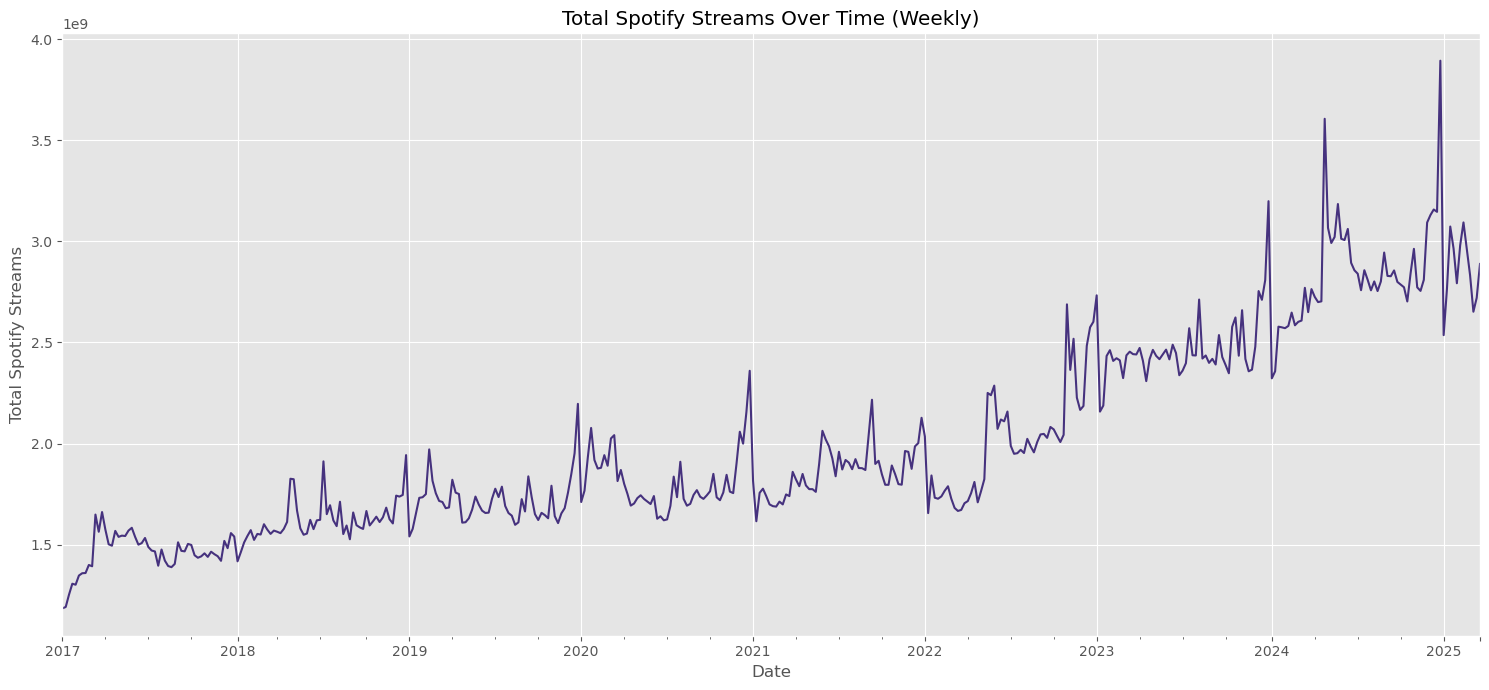

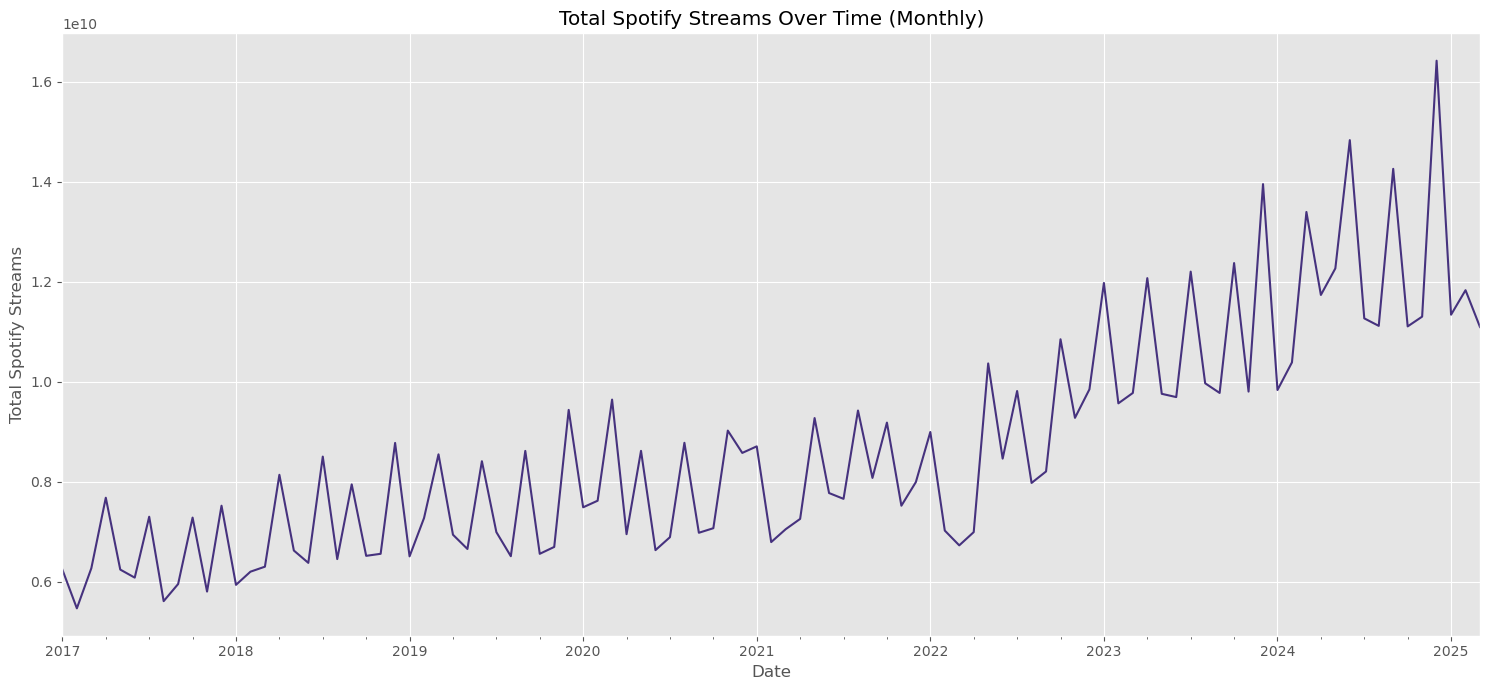

In [10]:
if not df.empty and 'date' in df.columns and 'spotify_streams' in df.columns and pd.api.types.is_datetime64_any_dtype(df['date']):
    df_temp_for_ts = df.copy()
    if not isinstance(df_temp_for_ts.index, pd.DatetimeIndex):
        df_temp_for_ts['date_dt'] = pd.to_datetime(df_temp_for_ts['date'])
        df_temp_for_ts = df_temp_for_ts.set_index('date_dt')
        
    df_time_series_weekly = df_temp_for_ts.groupby(df_temp_for_ts.index)['spotify_streams'].sum()

    # Weekly Plot
    fig, ax = plt.subplots(figsize=(15, 7))
    df_time_series_weekly.plot(ax=ax, title='Total Spotify Streams Over Time (Weekly)')
    ax.set_ylabel('Total Spotify Streams')
    ax.set_xlabel('Date')
    ax.grid(True)
    plt.tight_layout()
    save_and_show()  # Save as plot_01.png
    plt.close(fig)

    # Monthly Plot
    fig, ax = plt.subplots(figsize=(15, 7))
    df_time_series_weekly.resample('M').sum().plot(ax=ax, title='Total Spotify Streams Over Time (Monthly)')
    ax.set_ylabel('Total Spotify Streams')
    ax.set_xlabel('Date')
    ax.grid(True)
    plt.tight_layout()
    save_and_show()  # Save as plot_02.png
    plt.close(fig)

else:
    print("Skipping time series plot: Conditions not met.")


### **Conclusion: Total Spotify Streams Over Time (Monthly)**

> **Key Takeaways:**  
> The monthly total streams on Spotify show a clear upward trend from 2017 to 2025, with consistent seasonal spikes.  

## 4.2 Seasonal Decomposition of Top Genre

Identified Top Deezer Genre by total streams: pop

### Seasonal Decomposition for Top Deezer Genre: pop ###

--- Decomposing: pop ---


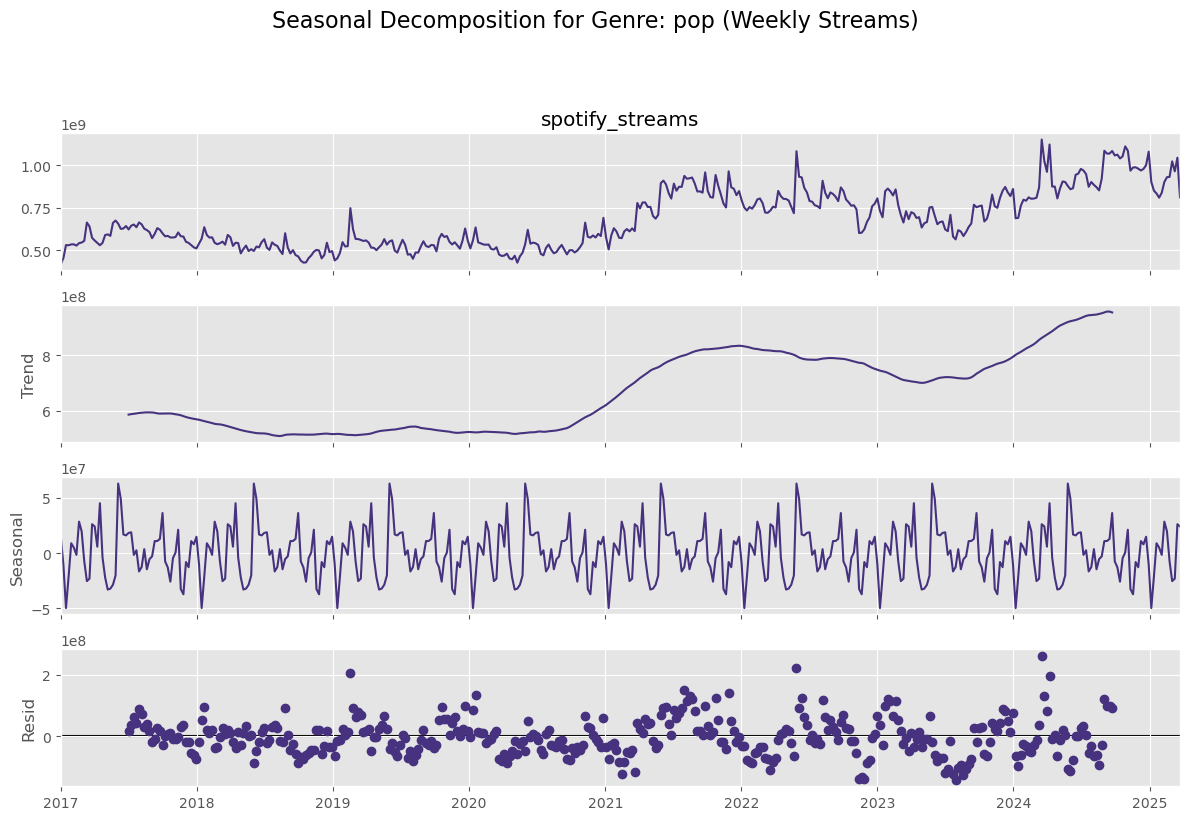

In [11]:
seasonal_period = 52
top_deezer_genre_name = None
deezer_genre_cols = []

if not df.empty:
    deezer_genre_cols = [col for col in df.columns if col.startswith('deezer_genre_') and df[col].dtype in ['int64', 'float64', 'int32', 'float32', 'uint8']]

    if deezer_genre_cols and 'spotify_streams' in df.columns:
        deezer_genre_streams_total = {}
        for genre_col_name_full in deezer_genre_cols:
            clean_name = genre_col_name_full.replace('deezer_genre_', '')
            deezer_genre_streams_total[clean_name] = df[df[genre_col_name_full] == 1]['spotify_streams'].sum()
        
        if deezer_genre_streams_total:
            top_deezer_genre_name = pd.Series(deezer_genre_streams_total).sort_values(ascending=False).index[0]
            print(f"Identified Top Deezer Genre by total streams: {top_deezer_genre_name}")
        else:
            print("Could not calculate total streams for any Deezer genre.")
    else:
        if not deezer_genre_cols:
            print("No 'deezer_genre_*' columns found in the DataFrame.")
        if 'spotify_streams' not in df.columns:
            print("'spotify_streams' column not found in the DataFrame.")

if not df.empty and top_deezer_genre_name and 'spotify_streams' in df.columns and 'date' in df.columns and pd.api.types.is_datetime64_any_dtype(df['date']):
    print(f"\n### Seasonal Decomposition for Top Deezer Genre: {top_deezer_genre_name} ###")
    
    df_ts_analysis_genre = df.set_index('date')
    genre_col_original_to_decompose = 'deezer_genre_' + top_deezer_genre_name 

    if genre_col_original_to_decompose in df_ts_analysis_genre.columns:
        print(f"\n--- Decomposing: {top_deezer_genre_name} ---")
        genre_series = df_ts_analysis_genre[df_ts_analysis_genre[genre_col_original_to_decompose] == 1]['spotify_streams'].resample('W').sum()
        genre_series.fillna(0, inplace=True)
        
        if len(genre_series) >= 2 * seasonal_period:
            try:
                decomposition_genre = seasonal_decompose(genre_series, model='additive', period=seasonal_period)
                
                fig_genre = decomposition_genre.plot()
                fig_genre.set_size_inches(12, 8)
                fig_genre.suptitle(f'Seasonal Decomposition for Genre: {top_deezer_genre_name} (Weekly Streams)', y=1.02, fontsize=16)
                plt.tight_layout(rect=[0, 0, 1, 0.96]) 
                save_and_show()
                
            except ValueError as ve:
                print(f"Could not decompose {top_deezer_genre_name}. Error: {ve}. This might be due to insufficient data points or other issues with the series.")
            except Exception as e:
                print(f"An unexpected error occurred during decomposition for {top_deezer_genre_name}: {e}")
        else:
            print(f"Skipping decomposition for {top_deezer_genre_name}: not enough data points (needs at least {2 * seasonal_period} weekly periods, has {len(genre_series)}).")
    else:
        print(f"Warning: Genre column '{genre_col_original_to_decompose}' not found for decomposition.")
else:
    if df.empty:
        print("DataFrame is empty. Skipping genre-specific seasonal decomposition.")
    elif not top_deezer_genre_name:
        print("Top Deezer genre was not identified. Skipping genre-specific seasonal decomposition.")
    else:
        print("Skipping genre-specific seasonal decomposition: 'spotify_streams' or 'date' column issues, or 'date' is not datetime.")

### **Conclusion: Seasonal Decomposition for Genre: Pop (Weekly Streams)**

> **Key Takeaways:**  
> - **Observed:** The overall weekly streams for Pop show variability with notable peaks and dips.  
> - **Trend:** There is a steady upward trend starting around 2021, reflecting growing popularity or engagement with Pop music.  
> - **Seasonal:** Strong recurring seasonal patterns are present, indicating regular listening cycles or release patterns.  
> - **Residual:** Residuals appear mostly randomly distributed, suggesting that the trend and seasonality capture most of the explainable variance.

## 4.3 ACF and PACF of Top 5 Genres

DEBUG: Calculated 'overall_streams_ts', length: 430
DEBUG: Calculated 'top_deezer_genres_by_streams' (top 3): ['pop', 'rap_hip_hop', 'latin_music']

### ACF/PACF for Overall Spotify Streams ###


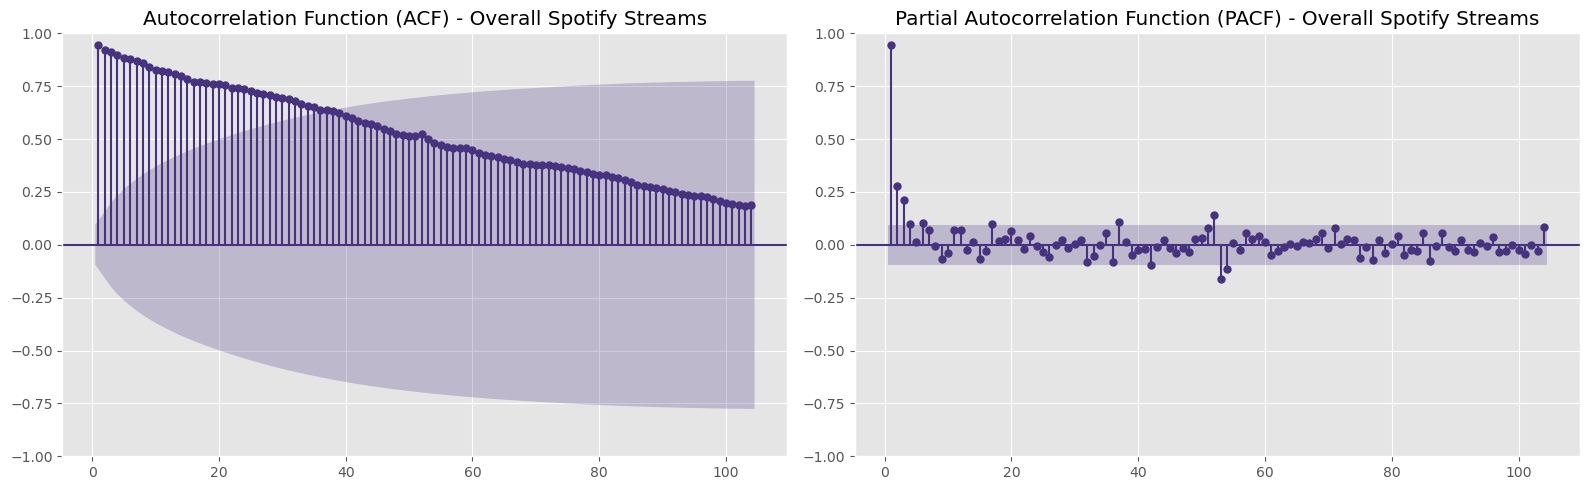


### ACF/PACF for Top Deezer Genres ###


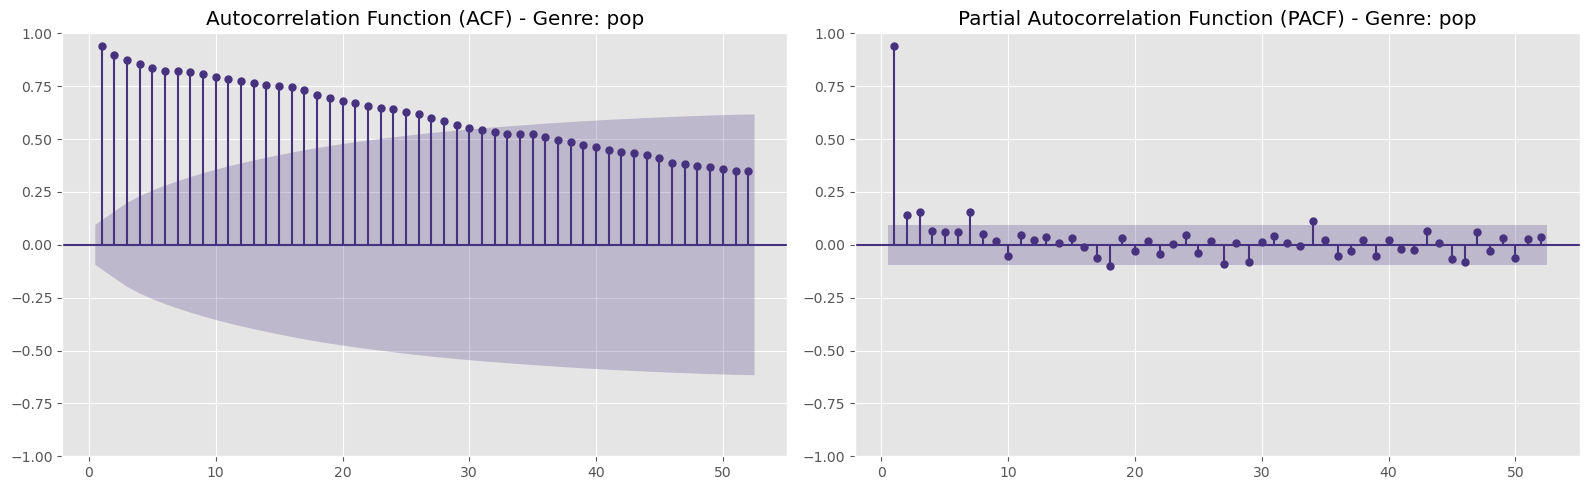

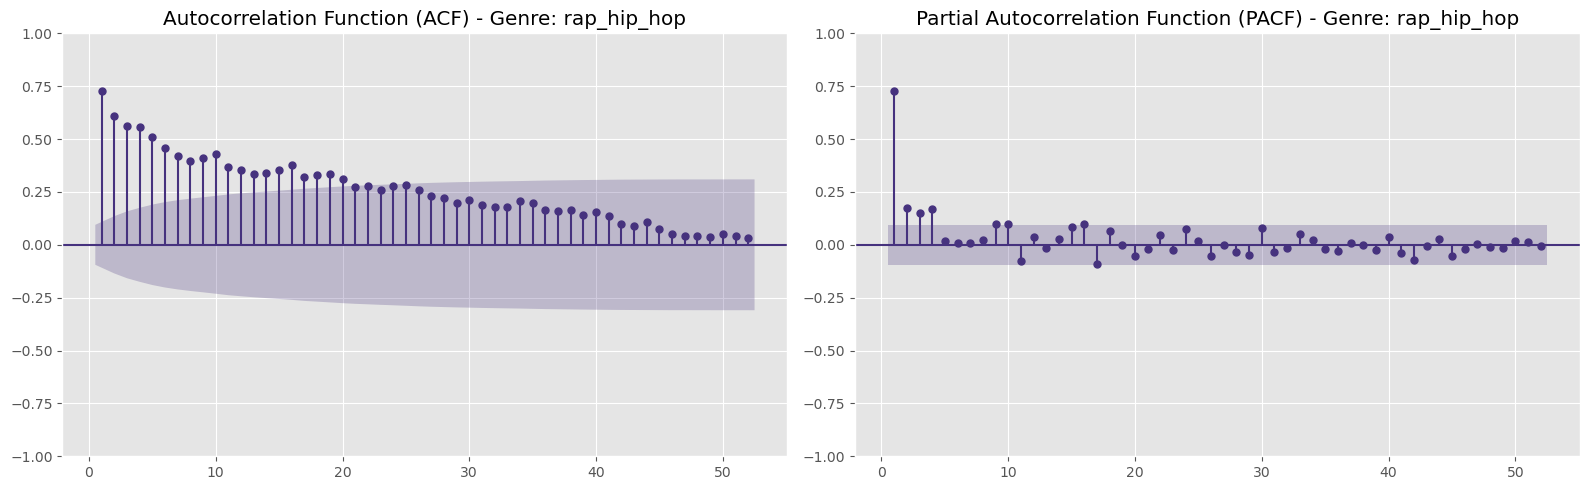

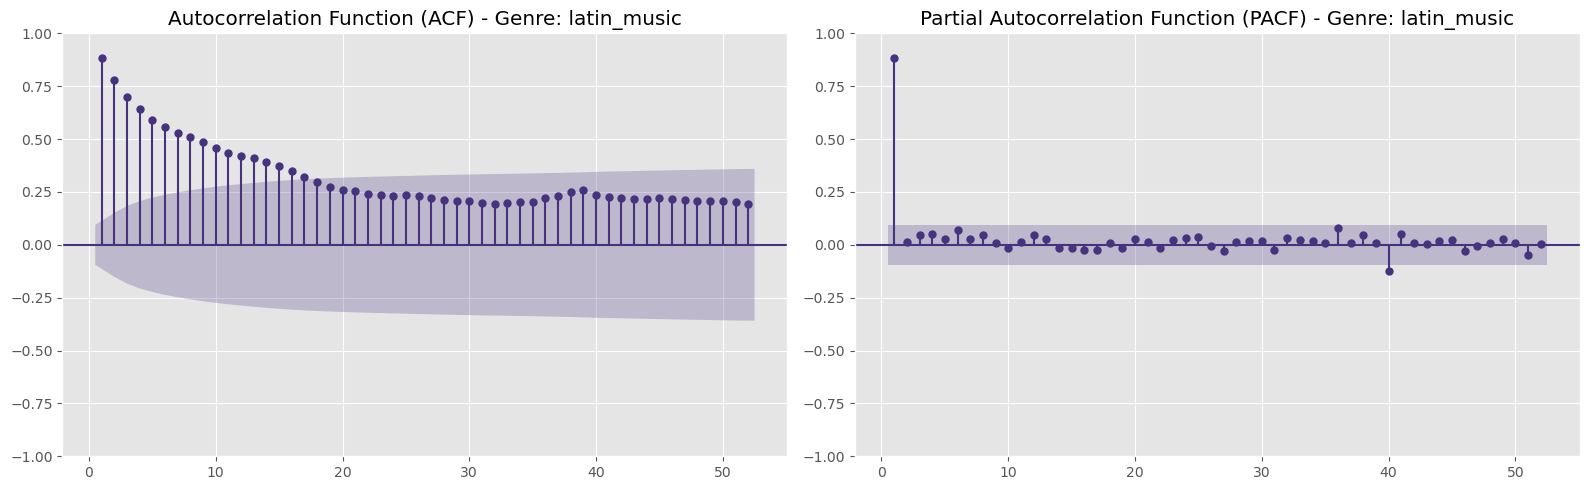

In [12]:
if not df.empty and 'date' in df.columns and 'spotify_streams' in df.columns and pd.api.types.is_datetime64_any_dtype(df['date']):
    overall_streams_ts = df.groupby('date')['spotify_streams'].sum().sort_index()
    overall_streams_ts = overall_streams_ts.asfreq('W') # Ensure weekly frequency
    overall_streams_ts.fillna(0, inplace=True) # Fill any gaps
    print(f"DEBUG: Calculated 'overall_streams_ts', length: {len(overall_streams_ts)}")
else:
    overall_streams_ts = None
    print("DEBUG: Could not calculate 'overall_streams_ts' due to missing df, date, or spotify_streams.")

if 'deezer_genre_cols' not in locals() or not deezer_genre_cols:
    print("DEBUG: 'deezer_genre_cols' not found, identifying now...")
    if not df.empty:
        deezer_genre_cols = [col for col in df.columns if col.startswith('deezer_genre_') and df[col].dtype in ['int64', 'float64', 'int32', 'float32', 'uint8']]
        print(f"DEBUG: Identified {len(deezer_genre_cols)} deezer_genre_cols.")
    else:
        deezer_genre_cols = []
        print("DEBUG: DataFrame is empty, cannot identify deezer_genre_cols.")

if not df.empty and deezer_genre_cols and 'spotify_streams' in df.columns:
    deezer_genre_streams_temp = {}
    for genre_col_name_full_local in deezer_genre_cols:
        clean_name_local = genre_col_name_full_local.replace('deezer_genre_', '')
        deezer_genre_streams_temp[clean_name_local] = df[df[genre_col_name_full_local] == 1]['spotify_streams'].sum()
    if deezer_genre_streams_temp:
        top_deezer_genres_by_streams = pd.Series(deezer_genre_streams_temp).sort_values(ascending=False).head(3).index.tolist()
        print(f"DEBUG: Calculated 'top_deezer_genres_by_streams' (top 3): {top_deezer_genres_by_streams}")
    else:
        top_deezer_genres_by_streams = []
        print("DEBUG: No Deezer genres found to calculate top_deezer_genres_by_streams.")
else:
    top_deezer_genres_by_streams = []
    print("DEBUG: Could not calculate 'top_deezer_genres_by_streams' due to missing df, deezer_genre_cols, or spotify_streams.")


def plot_acf_pacf_charts(series, series_name, lags=40):
    """
    Plots ACF and PACF for a given time series.
    """
    if series is None or series.empty:
        print(f"Skipping ACF/PACF for {series_name}: Series is empty or None.")
        return
    
    if len(series) < lags + 5 :
        actual_lags = max(1, len(series) // 2 - 1) 
        if actual_lags < 1: 
             print(f"Skipping ACF/PACF for {series_name}: Not enough data points for any meaningful lags (has {len(series)} points).")
             return
        print(f"Warning: Not enough data for {lags} lags for {series_name} (has {len(series)} points). Using {actual_lags} lags instead.")
        lags = actual_lags
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    try:
        series_cleaned = series.dropna()
        if len(series_cleaned) < lags + 2 :
            print(f"Skipping ACF/PACF for {series_name} after dropna: Not enough data points (has {len(series_cleaned)}).")
            plt.close(fig) 
            return

        plot_acf(series_cleaned, ax=axes[0], lags=lags, zero=False) 
        axes[0].set_title(f'Autocorrelation Function (ACF) - {series_name}')
        
        plot_pacf(series_cleaned, ax=axes[1], lags=lags, zero=False, method='ywm') 
        axes[1].set_title(f'Partial Autocorrelation Function (PACF) - {series_name}')
        
        plt.tight_layout()
        save_and_show()
    except Exception as e:
        print(f"Error plotting ACF/PACF for {series_name}: {e}")
        if 'fig' in locals(): # Attempt to close figure if created
            plt.close(fig)


if 'overall_streams_ts' in locals() and overall_streams_ts is not None and not overall_streams_ts.empty:
    print("\n### ACF/PACF for Overall Spotify Streams ###")
    # Show more lags for overall series if data permits, e.g., up to 2 years for weekly data
    plot_acf_pacf_charts(overall_streams_ts, "Overall Spotify Streams", lags=min(104, len(overall_streams_ts)//2 -1))
else:
    print("Skipping ACF/PACF for overall streams as 'overall_streams_ts' is not available or empty.")

if not df.empty and 'top_deezer_genres_by_streams' in locals() and top_deezer_genres_by_streams:
    print("\n### ACF/PACF for Top Deezer Genres ###")
    # Ensure 'date' is index for time series operations if df is not already indexed by date
    if not isinstance(df.index, pd.DatetimeIndex) and 'date' in df.columns:
        df_ts_for_acf_pacf = df.set_index('date')
    elif isinstance(df.index, pd.DatetimeIndex):
        df_ts_for_acf_pacf = df.copy() # Use if df already has DatetimeIndex
    else:
        print("Warning: Cannot set DatetimeIndex for genre ACF/PACF plots. 'date' column missing or not datetime.")
        df_ts_for_acf_pacf = None

    if df_ts_for_acf_pacf is not None:
        num_genres_to_plot_acf = min(len(top_deezer_genres_by_streams), 3) # Limit to top 3 for brevity
        
        for genre_name_clean in top_deezer_genres_by_streams[:num_genres_to_plot_acf]:
            genre_col_original = 'deezer_genre_' + genre_name_clean
            if genre_col_original in df_ts_for_acf_pacf.columns:
                # Create a time series for the current genre
                genre_series = df_ts_for_acf_pacf[df_ts_for_acf_pacf[genre_col_original] == 1]['spotify_streams'].resample('W').sum()
                genre_series.fillna(0, inplace=True) # Fill any gaps that might arise from resampling with 0
                
                if not genre_series.empty:
                    plot_acf_pacf_charts(genre_series, f"Genre: {genre_name_clean}", lags=52) # Up to 1 year of weekly lags
                else:
                    print(f"No stream data found for genre '{genre_name_clean}' after resampling for ACF/PACF.")
            else:
                print(f"Warning: Genre column '{genre_col_original}' not found for ACF/PACF plots.")
else:
    print("Skipping ACF/PACF for top genres: DataFrame is empty or top genres not identified.")

### **Conclusion: ACF & PACF Analysis Across Genres and Overall Spotify Streams**

> **Key Takeaways:**  
> - **Autocorrelation (ACF):**  
>   All genres (Latin, Rap/Hip-Hop, Pop) and overall streams exhibit strong autocorrelation, gradually decreasing across lags.  
>   Pop and overall streams show particularly slow decay, indicating long-term memory and persistence in the streaming patterns.  
>   Latin and Rap/Hip-Hop decay faster but still show notable dependency across multiple lags.
> 
> - **Partial Autocorrelation (PACF):**  
>   All genres exhibit a sharp drop after the first lag, suggesting that the most relevant predictive information lies in the immediate past (lag 1).  

## 5. Genre and Tag Analysis

Identified 49 Deezer genre columns.


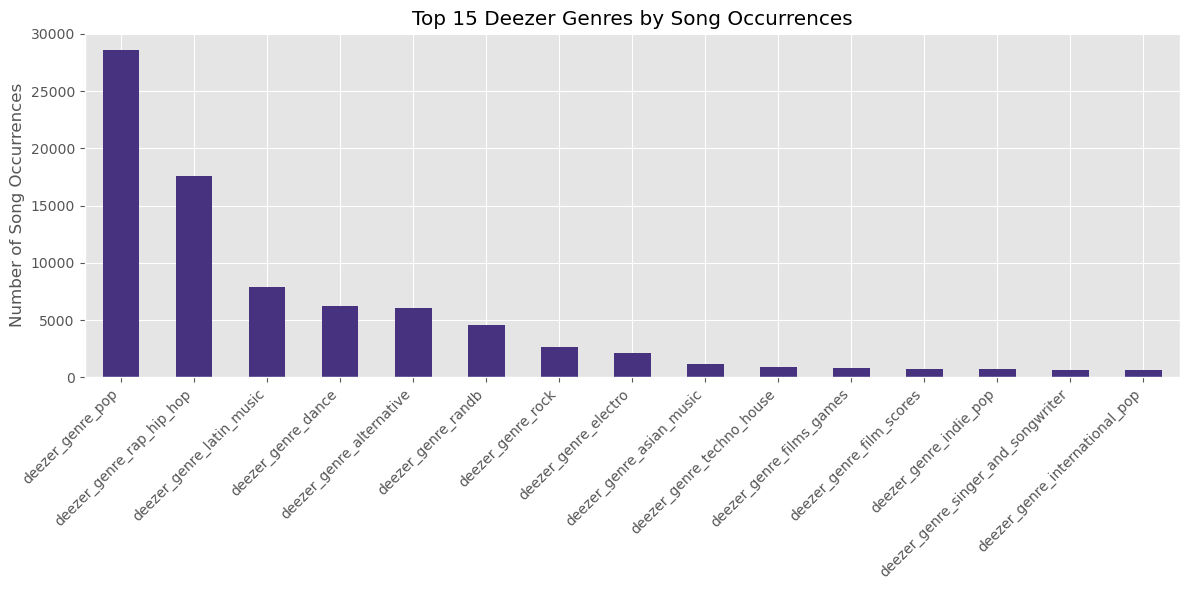

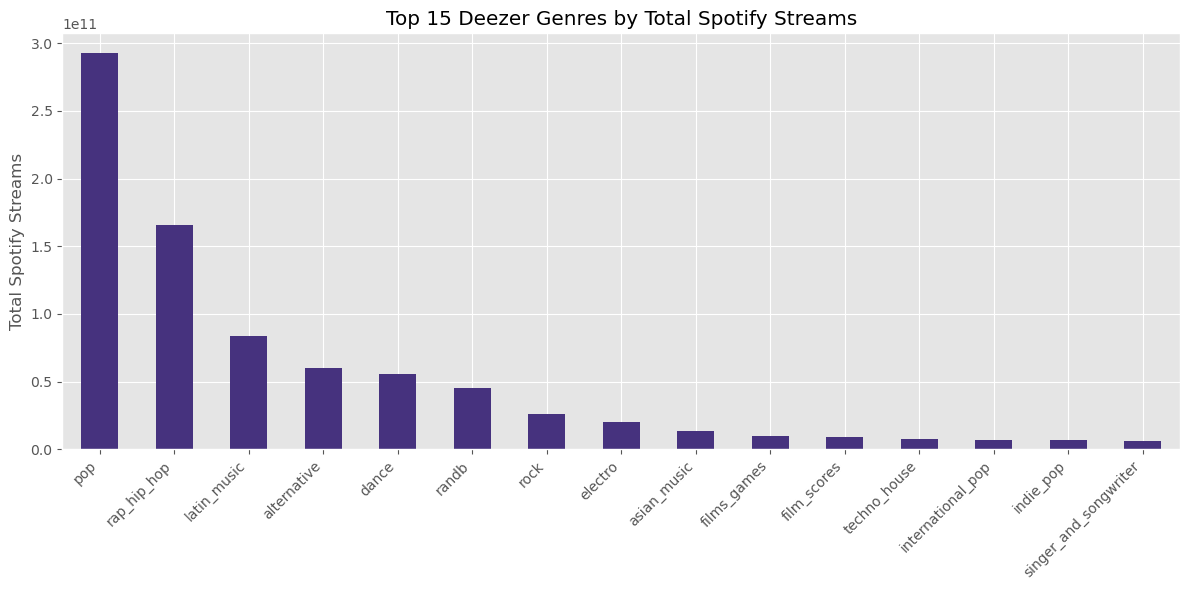

In [13]:
if not df.empty:
    print(f"Identified {len(deezer_genre_cols)} Deezer genre columns.")
    if deezer_genre_cols:
        # Popularity by song occurrences
        deezer_genre_counts = df[deezer_genre_cols].sum().sort_values(ascending=False)
        plt.figure(figsize=(12, 6))
        deezer_genre_counts.head(15).plot(kind='bar', title='Top 15 Deezer Genres by Song Occurrences')
        plt.ylabel('Number of Song Occurrences'); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); save_and_show()
        
        # Popularity by streams
        if 'spotify_streams' in df.columns:
            deezer_genre_streams = {}
            for genre_col in deezer_genre_cols:
                clean_name = genre_col.replace('deezer_genre_', '')
                deezer_genre_streams[clean_name] = df[df[genre_col] == 1]['spotify_streams'].sum()
            pd.Series(deezer_genre_streams).sort_values(ascending=False).head(15).plot(kind='bar', figsize=(12,6), title='Top 15 Deezer Genres by Total Spotify Streams')
            plt.ylabel('Total Spotify Streams'); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); save_and_show()
            top_deezer_genres_by_streams = pd.Series(deezer_genre_streams).sort_values(ascending=False).head(5).index.tolist()
        else:
            top_deezer_genres_by_streams = []
            print("'spotify_streams' column missing, cannot calculate popularity by streams for Deezer genres.")
else:
    deezer_genre_cols = []
    top_deezer_genres_by_streams = []
    print("DataFrame empty or no Deezer genre columns found.")

### **Conclusion: Top Deezer Genres by Streams and Song Counts**

> **Key Takeaways:**  
>   Pop, Rap/Hip-Hop, and Latin Music are the leading genres in terms of total Spotify streams, with Pop being nearly double Rap/Hip-Hop.  
> 


### 5.2 Boxplots of strems by Top Genres

For a quick, interpretable comparison, pick your top 5 most frequent Deezer genres and examine how core targets vary by genre membership:

- For each genre flag (0 vs. 1), draw boxplots of:  
  - `spotify_Streams`  

This will highlight whether, for example, “Pop” tracks truly outperform in streams or chart longevity versus non-Pop tracks.


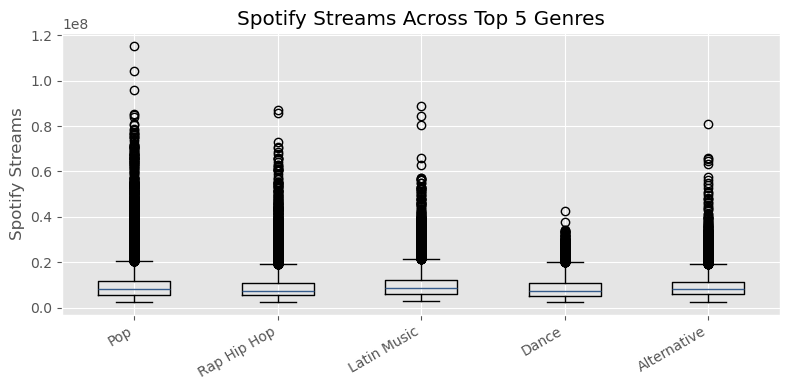

In [14]:
genre_cols = [c for c in df.columns if c.startswith("deezer_genre_")]
genre_sums = df[genre_cols].sum(numeric_only=True)
top5 = genre_sums.nlargest(5).index.tolist()
metrics = ["spotify_streams"]

for metric in metrics:
    data = [
        df.loc[df[genre] == 1, metric].dropna() 
        for genre in top5
    ]
    labels = [
        genre.replace("deezer_genre_", "").replace("_", " ").title() 
        for genre in top5
    ]

    plt.figure(figsize=(8, 4))
    plt.boxplot(data, labels=labels)
    plt.title(f"{metric.replace('_', ' ').title()} Across Top 5 Genres")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel(metric.replace("_", " ").title())
    plt.tight_layout()
    save_and_show()



### **Conclusion: Spotify Streams Distribution Across Top 5 Genres**

> **Key Takeaways:**  
> The boxplot shows that while Pop, Rap/Hip-Hop, and Latin Music have slightly higher median stream counts, all five genres have wide distributions with many extreme outliers.  
> This indicates that within each genre, a small number of songs achieve exceptionally high streaming numbers, while most songs perform more moderately.


## 6. Feature Exploration

### 6.1. Distribution of Key Numerical Features

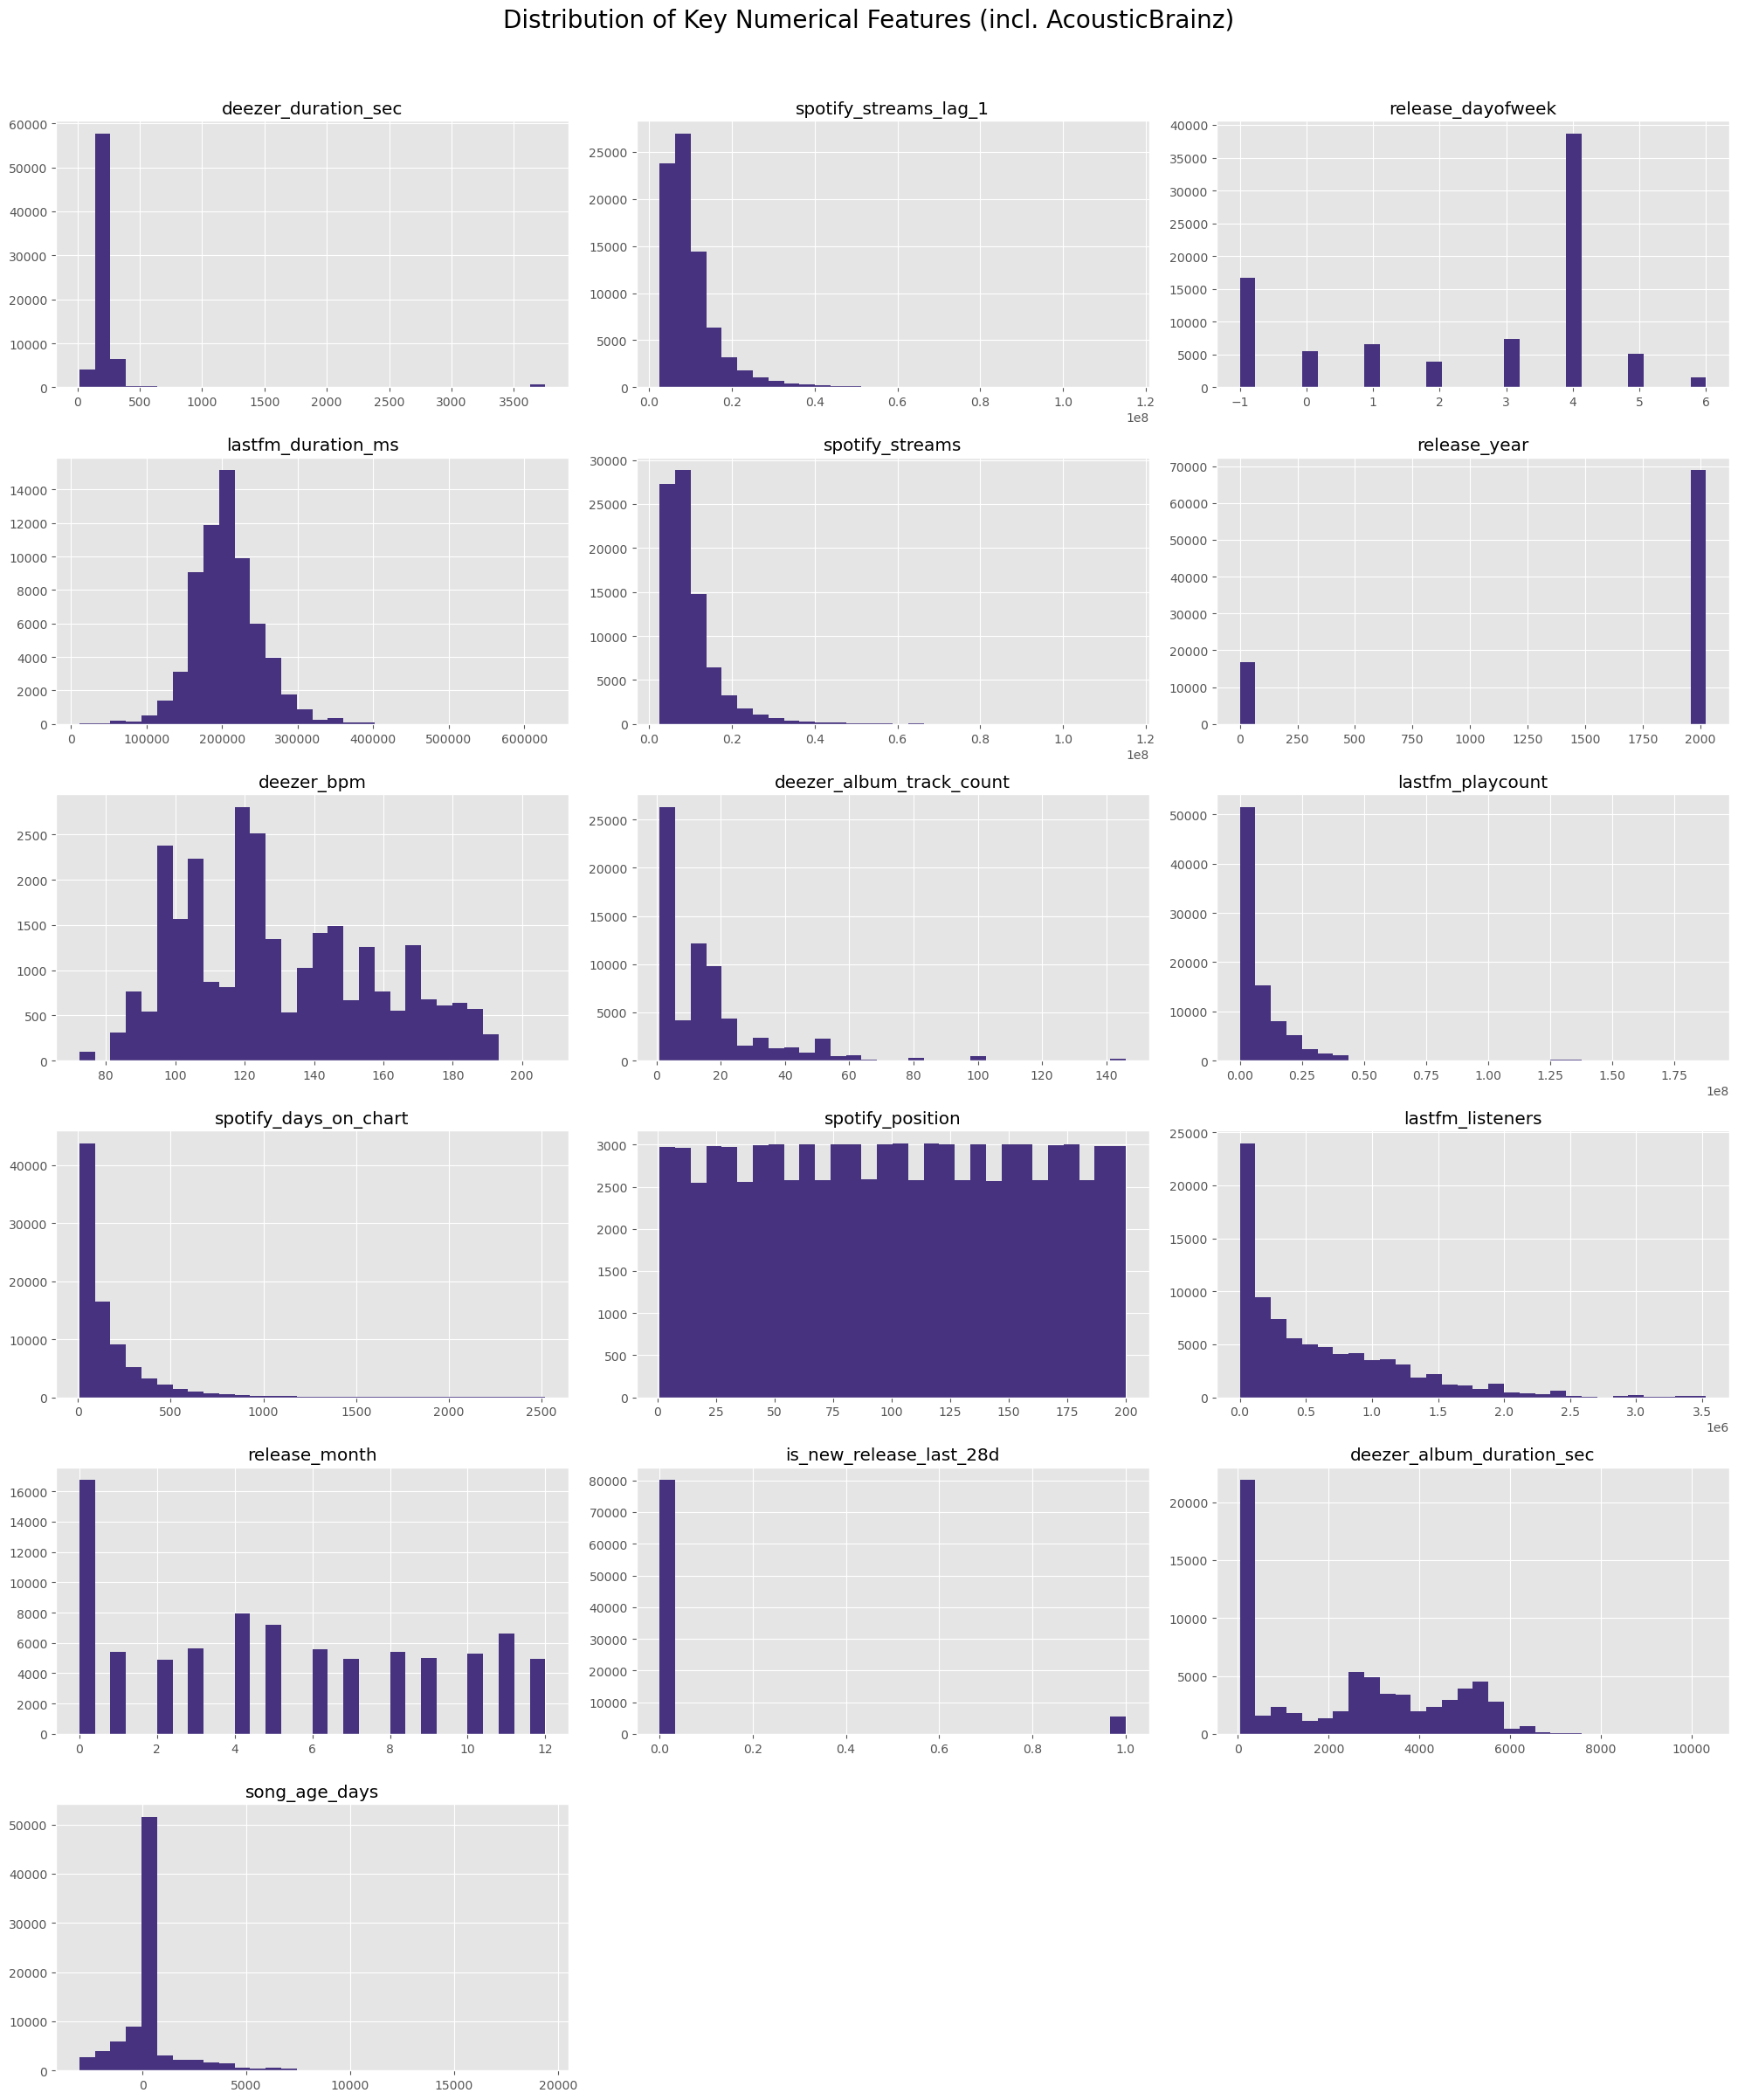

In [15]:
if not df.empty:
    # Identify all numeric acoustic_prob columns that are binary (0 or 1)
    binary_acoustic_prob_cols = []
    if 'acoustic_prob_cols' in locals() and acoustic_prob_cols: # Check if acoustic_prob_cols was defined
        for col in acoustic_prob_cols:
            if col in df.columns and df[col].dropna().isin([0, 1]).all():
                binary_acoustic_prob_cols.append(col)
    
    numerical_features_for_dist = [
        'spotify_streams', 'spotify_position', 'spotify_peakposition', 
        'spotify_weeksonchart', 'spotify_days_on_chart',
        'avg_position', 'avg_peak_position', 'combined_days_on_chart',
        'lastfm_listeners', 'lastfm_playcount', 'lastfm_duration_ms',
        'song_age_days', 'release_year', 'release_month', 'release_dayofweek', 
        'is_new_release_last_28d',
        'deezer_album_track_count', 'deezer_album_duration_sec', 'deezer_bpm', 'deezer_duration_sec'
    ] + binary_acoustic_prob_cols # Add binarized acoustic_prob features
    
    if 'other_numeric_acoustic_cols' in locals() and other_numeric_acoustic_cols: # Add other numeric acoustic if they exist
        numerical_features_for_dist.extend(other_numeric_acoustic_cols)
        
    if 'spotify_lastweek' in df.columns: 
        numerical_features_for_dist.append('spotify_lastweek')
    elif 'spotify_streams_lag_1' in df.columns:
        numerical_features_for_dist.append('spotify_streams_lag_1')

    numerical_features_present = [feat for feat in list(set(numerical_features_for_dist)) 
                                  if feat in df.columns and pd.api.types.is_numeric_dtype(df[feat])]

    if numerical_features_present:
        num_plots = len(numerical_features_present)
        cols_layout = 3 
        rows_layout = (num_plots + cols_layout - 1) // cols_layout
        fig_height_dynamic = max(15, rows_layout * 4)
        
        df[numerical_features_present].hist(bins=30, figsize=(20, fig_height_dynamic), layout=(rows_layout, cols_layout))
        plt.suptitle('Distribution of Key Numerical Features (incl. AcousticBrainz)', size=20, y=1.00)
        plt.tight_layout(rect=[0, 0, 1, 0.98]) 
        save_and_show()
    else:
        print("No specified numerical features found for plotting distributions.")
else:
    print("DataFrame is empty, skipping numerical feature distribution plots.")

**Observations from Distributions:**
- Binarized `acoustic_*_prob` features show as bar charts with two bars (0 and 1).

### 6.2. Correlation Analysis

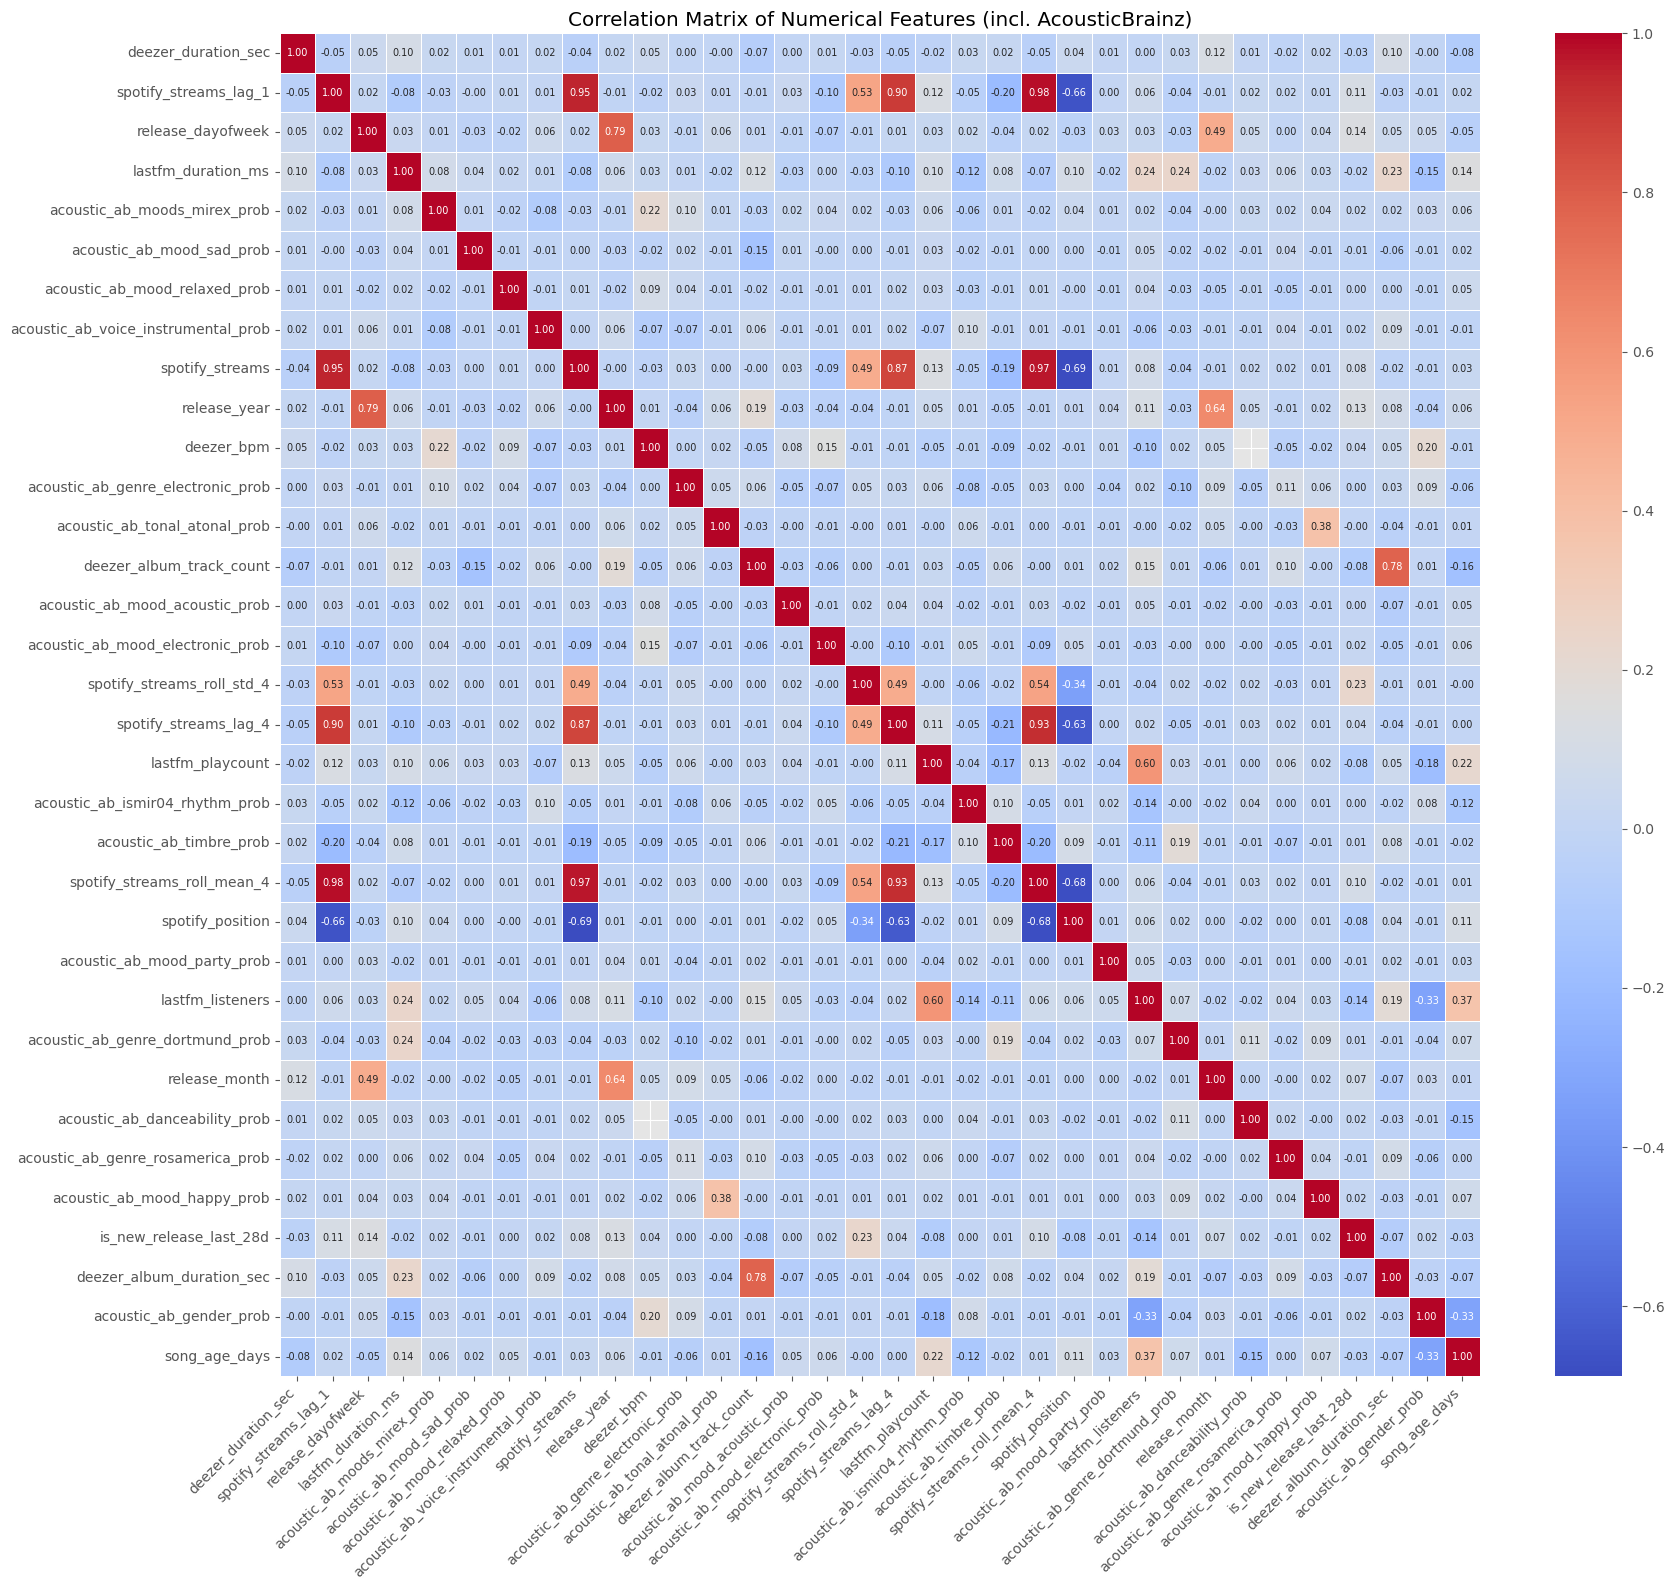


Correlations with 'spotify_streams':
spotify_streams                        1.000000
spotify_streams_roll_mean_4            0.969134
spotify_streams_lag_1                  0.950573
spotify_streams_lag_4                  0.868449
spotify_streams_roll_std_4             0.494724
lastfm_playcount                       0.134406
is_new_release_last_28d                0.082266
lastfm_listeners                       0.080486
acoustic_ab_genre_electronic_prob      0.029923
song_age_days                          0.026881
acoustic_ab_mood_acoustic_prob         0.026795
acoustic_ab_danceability_prob          0.022040
acoustic_ab_genre_rosamerica_prob      0.015975
release_dayofweek                      0.015376
acoustic_ab_mood_relaxed_prob          0.012860
acoustic_ab_mood_happy_prob            0.009607
acoustic_ab_mood_party_prob            0.005686
acoustic_ab_voice_instrumental_prob    0.004697
acoustic_ab_tonal_atonal_prob          0.004508
acoustic_ab_mood_sad_prob              0.002289
de

In [16]:
if not df.empty:
    # Re-fetch binary_acoustic_prob_cols and other_numeric_acoustic_cols if not in scope or might have changed
    acoustic_cols_corr = [col for col in df.columns if col.startswith('acoustic_') and pd.api.types.is_numeric_dtype(df[col])]
    # Exclude non-binarized _prob if any slipped through, and _value columns (should be dropped by ETL)
    acoustic_cols_for_corr = []
    for col in acoustic_cols_corr:
        if col.endswith('_prob'):
            if df[col].dropna().isin([0,1]).all(): # Only include if truly binary (0,1)
                acoustic_cols_for_corr.append(col)
        elif not col.endswith('_value'): # Exclude value columns explicitly
            acoustic_cols_for_corr.append(col)
            
    correlation_candidate_features = [
        'spotify_streams', 'spotify_position', 'spotify_peakposition', 'spotify_weeksonchart',
        'avg_position', 'avg_peak_position', 'combined_days_on_chart',
        'lastfm_listeners', 'lastfm_playcount', 'lastfm_duration_ms',
        'song_age_days', 'release_year', 'release_month', 'release_dayofweek', 'is_new_release_last_28d',
        'deezer_album_track_count', 'deezer_album_duration_sec', 'deezer_bpm', 'deezer_duration_sec'
    ] + acoustic_cols_for_corr + [ # Add relevant AcousticBrainz features
        'spotify_streams_lag_1', 'spotify_streams_lag_4', 
        'spotify_streams_roll_mean_4', 'spotify_streams_roll_std_4'
    ]
    if 'spotify_lastweek' in df.columns and 'spotify_streams_lag_1' not in correlation_candidate_features:
        correlation_candidate_features.append('spotify_lastweek')

    valid_correlation_features = [f for f in list(set(correlation_candidate_features)) 
                                  if f in df.columns and pd.api.types.is_numeric_dtype(df[f])]
    
    if valid_correlation_features and 'spotify_streams' in valid_correlation_features:
        if len(valid_correlation_features) > 35: # Further adjust threshold if needed
            print(f"Warning: {len(valid_correlation_features)} features selected for correlation matrix. Plot might be very large/dense.")
        
        correlation_matrix = df[valid_correlation_features].corr()
        num_corr_features = len(valid_correlation_features)
        fig_size_corr = max(14, int(num_corr_features * 0.55))
        
        plt.figure(figsize=(fig_size_corr, fig_size_corr - 2))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, annot_kws={"size": 7})
        plt.title('Correlation Matrix of Numerical Features (incl. AcousticBrainz)')
        plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout(); save_and_show()
        
        print("\nCorrelations with 'spotify_streams':")
        if 'spotify_streams' in correlation_matrix.columns:
             print(correlation_matrix['spotify_streams'].sort_values(ascending=False))
        else:
            print("'spotify_streams' column not found in the correlation matrix after filtering.")
    elif 'spotify_streams' not in valid_correlation_features:
        print("'spotify_streams' not found or not numeric among candidate features for correlation.")
    else:
        print("No valid numerical features found for correlation analysis or 'spotify_streams' is missing.")
else:
    print("Skipping correlation analysis: DataFrame is empty.")

### **Conclusion: Correlation Matrix of Numerical Features**

> **Key Takeaways:**  
> - **Strongest Positive Correlations:**  
>   Spotify streams are highly correlated with their own lagged values (`lag_1`, `lag_4`) and rolling mean (`roll_mean_4`), confirming that recent performance is a strong predictor of current streams.  
>   Moderate correlation with `lastfm_playcount` suggests that cross-platform engagement is somewhat aligned.
> 
> - **Weak or Negligible Correlations:**  
>   Most acoustic features and song metadata show very weak correlations, indicating limited direct influence on stream volume.
> 
> - **Strongest Negative Correlations:**  
>   `spotify_position`, show strong negative correlations with streams, reflecting that higher-ranked songs (lower numerical positions) tend to have significantly more streams.

## 7. Conclusion of EDA

> **Summary of Insights:**  
> - **Trend Analysis:**  
>   Spotify streaming data shows a clear long-term growth trend with seasonal patterns across all genres.
> 
> - **Genre Insights:**  
>   These top genres not only lead in total streams but also in the number of songs, emphasizing their market dominance.
> 
> - **Distribution Observations:**  
>   Most genres exhibit wide variability in streaming performance, with a few songs achieving disproportionately high streams (outliers).
> 
> - **Position and Streams Relationship:**  
>   Chart positions are strongly tied to stream volumes, showing the importance of ranking performance in driving user engagement.
> 
> - **Autocorrelation Patterns:**  
>   Strong autocorrelation and partial autocorrelation patterns across all genres suggest that past performance is a meaningful predictor of future streams, supporting the choice of time series modeling.
> 
> - **Feature Correlations:**  
>   Lagged streams and chart positions are the strongest predictors, while acoustic and metadata features show limited direct influence.
> 
> **Next Steps:**  
> Based on these findings, the dataset is well-suited for time series forecasting.  
> The following models will be implemented and compared: SARIMA, Prophet, Naive, Moving Average, and Random Forest Regressor, to evaluate their forecasting performance on genre-level streaming trends.
